In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomocupy.magnification import M
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin


%matplotlib inline

cp.cuda.Device(0).use()

<CUDA Device 0>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 1024  # object size in each dimension
ntheta = 1  # number of angles (rotations)

center = n/2  # rotation axis

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8

## Read data

In [3]:
data00 = np.zeros([ntheta, ndist, n, n], dtype='float32')
ref00 = np.zeros([1, ndist, n, n], dtype='float32')

for k in range(ndist):
    data00[:, k] = dxchange.read_tiff(f'data/data_{n}_{k}.tiff')[:ntheta]
    ref00[:, k] = dxchange.read_tiff(f'data/ref_{n}_{k}.tiff')
shifts_drift_init = np.load('data/shifts_drift.npy')[:ntheta, :ndist]
shifts_ref_init = np.load('data/shifts_ref.npy')[:ntheta, :ndist]
shifts_ref0_init = np.load('data/shifts_ref0.npy')[:, :ndist]
shifts_init = shifts_drift_init

# Find shifts of reference images

In [4]:
shifts_ref0 = np.zeros([1, ndist, 2], dtype='float32')
for k in range(ndist):
    shifts_ref0[:, k] = registration_shift(ref00[:, k], ref00[:, 0], upsample_factor=1000)

print(f'Found shifts: \n{shifts_ref0=}')
print(f'Correct shifts: \n{shifts_ref0_init=}')

shifts_ref = np.zeros([ntheta, ndist, 2], dtype='float32')
for k in range(ndist):
    im = np.tile(ref00[0, 0], [ntheta, 1, 1])
    shifts_ref[:, k] = registration_shift(data00[:, k], im, upsample_factor=1000)
    
print(f'Found shifts: \n{shifts_ref=}')
print(f'Correct shifts: \n{shifts_ref_init=}')


Found shifts: 
shifts_ref0=array([[[ 0.   ,  0.   ],
        [ 0.726,  1.806],
        [-1.972,  0.045],
        [ 1.251,  0.431]]], dtype=float32)
Correct shifts: 
shifts_ref0_init=array([[[ 0.        ,  0.        ],
        [ 0.74143934,  1.8135734 ],
        [-1.9842069 ,  0.048769  ],
        [ 1.2504838 ,  0.45010424]]], dtype=float32)
Found shifts: 
shifts_ref=array([[[ 1.074, -1.906],
        [ 0.503,  0.998],
        [-0.01 , -1.09 ],
        [-1.207,  1.037]]], dtype=float32)
Correct shifts: 
shifts_ref_init=array([[[ 1.0852826 , -1.9169922 ],
        [ 0.53459287,  0.9952154 ],
        [-0.00597191, -1.1008134 ],
        [-1.2077485 ,  1.0421228 ]]], dtype=float32)


### Assuming the shifts are calculated, shifts refs back

In [5]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):
    # shift refs back
    ref0[:, k] = ST(ref0[:, k].astype('complex64'), shifts_ref0[:, k]).real

ref0c = np.tile(np.array(ref0), (ntheta, 1, 1, 1))
for k in range(ndist):
    # shift refs the position where they were when collecting data
    ref0c[:, k] = S(ref0c[:, k].astype('complex64'), shifts_ref[:, k]).real

In [6]:
rdata = data0/ref0c

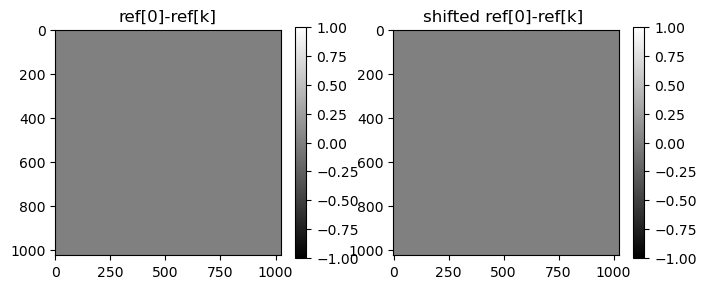

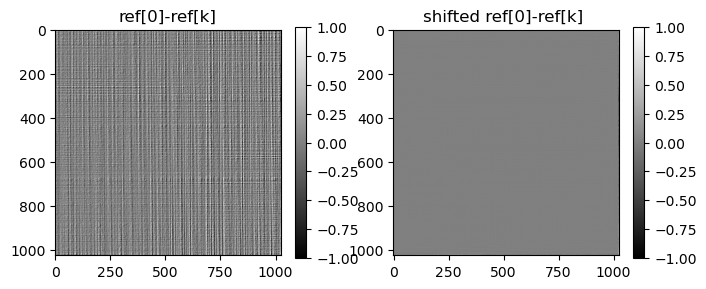

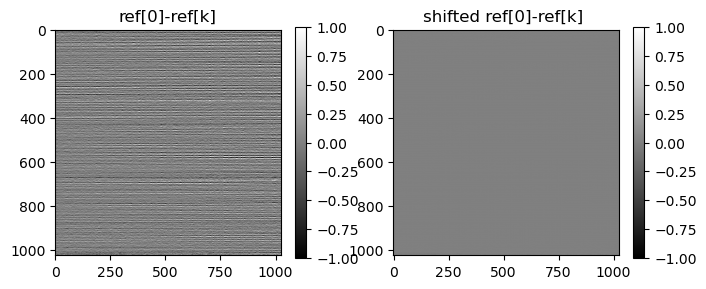

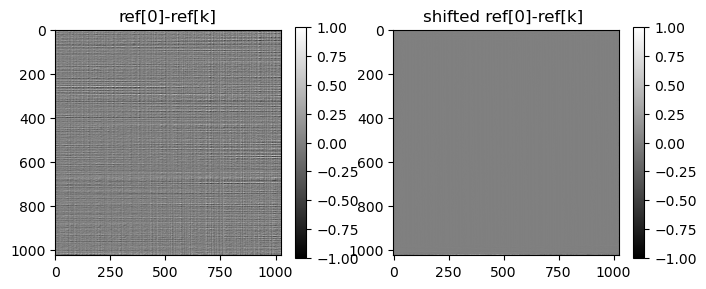

In [7]:
for k in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im = axs[0].imshow(ref00[0, 0]-ref00[0, k], cmap='gray',vmax=1,vmin=-1)
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    # ,vmin=-500,vmax=500)
    im = axs[1].imshow(ref0[0, 0]-ref0[0, k], cmap='gray',vmax=1,vmin=-1)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

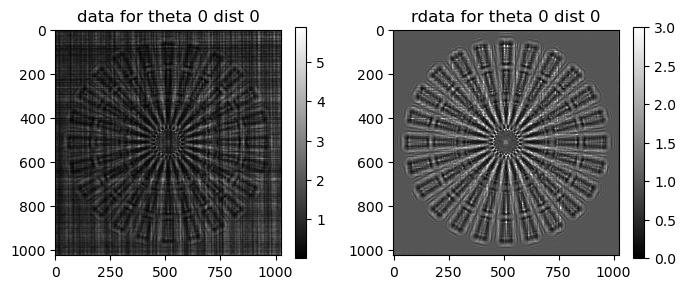

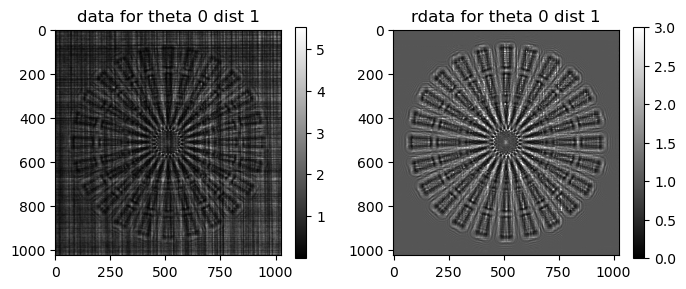

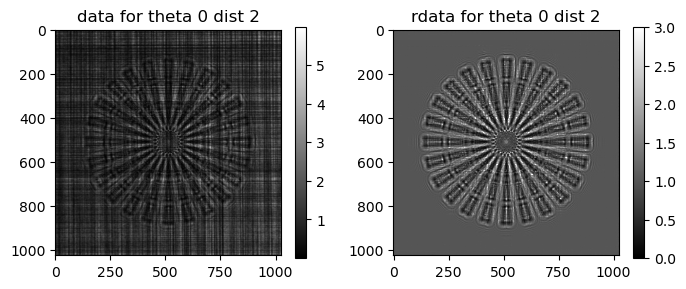

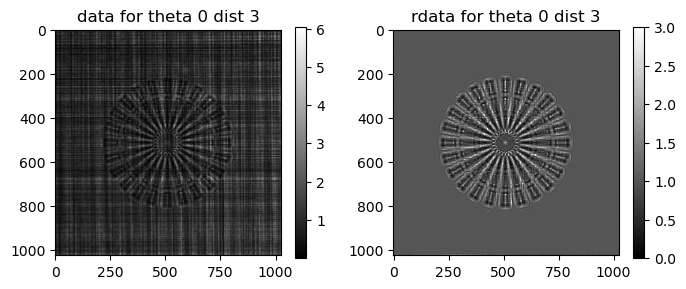

In [8]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im=axs[0].imshow(data0[-1,k],cmap='gray')#,vmin = 0.5,vmax=2 )
    axs[0].set_title(f'data for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[-1,k],cmap='gray',vmin = 0,vmax=3)
    axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
    fig.colorbar(im)

### Scale images

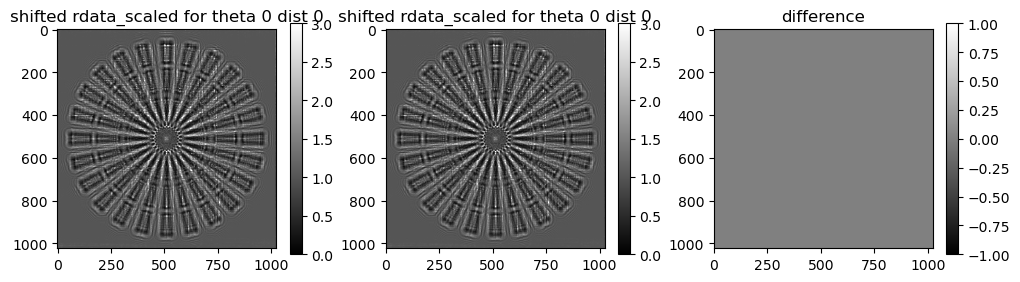

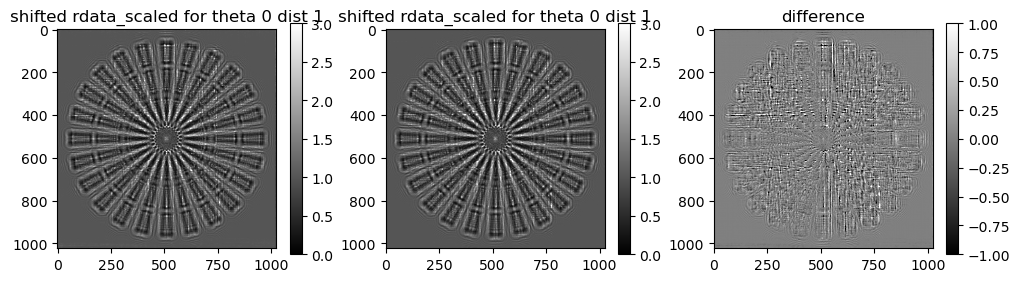

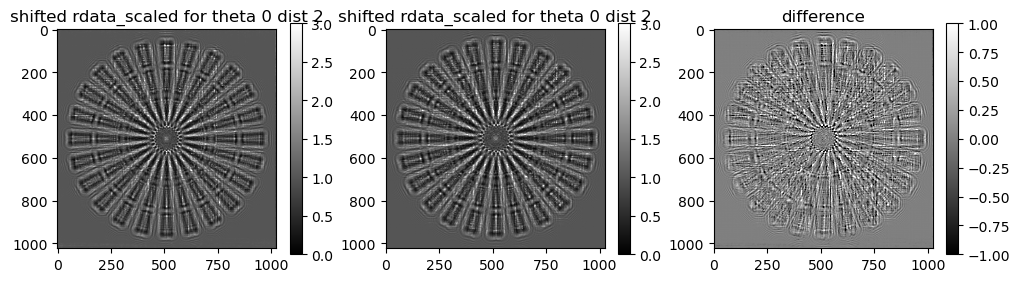

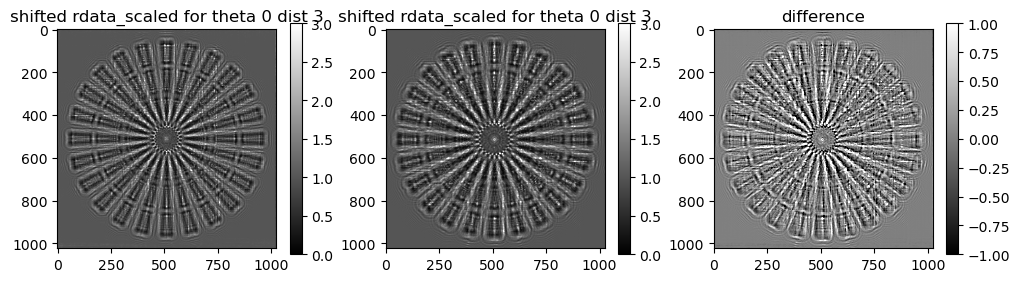

In [9]:
rdata_scaled = rdata.copy()

for k in range(ndist):
    rdata_scaled[:, k] = M(rdata_scaled[:, k], 1/norm_magnifications[k], n).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    im = axs[0].imshow(rdata_scaled[0, 0], cmap='gray', vmin=0, vmax=3)
    axs[0].set_title(f'shifted rdata_scaled for theta 0 dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled[0, k], cmap='gray', vmin=0, vmax=3)
    axs[1].set_title(f'shifted rdata_scaled for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled[0, k]-rdata_scaled[0, 0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

### Align images between different planes


#### Approach 1. Align data

In [10]:
# shifts_drift = np.zeros([ntheta,ndist,2],dtype='float32')

# for k in range(1,ndist):
#     shifts_drift[:,k] = registration_shift(rdata_scaled[:,k],rdata_scaled[:,0],upsample_factor=1000)

# # note shifts_drift should be after magnification.
# shifts_drift*=norm_magnifications[np.newaxis,:,np.newaxis]

# shifts_drift_median = shifts_drift.copy()
# shifts_drift_median[:] = np.median(shifts_drift,axis=0)

# print(shifts_drift_median[0],shifts_drift_init[0])
# for k in range(ndist):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 3))
#     im=axs[0].plot(shifts_drift[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_median[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_init[:,k,0],'r.')
#     axs[0].set_title(f'distance {k}, shifts y')
#     im=axs[1].plot(shifts_drift[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_median[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_init[:,k,1],'r.')
#     axs[1].set_title(f'distance {k}, shifts x')
#     # plt.show()

#### Approach 2. Align CTF reconstructions from 1 distance

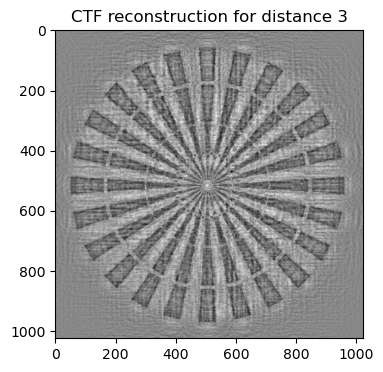

Found shifts: 
shifts_drift=array([[[ 0.        ,  0.        ],
        [ 0.67308944,  0.3528446 ],
        [-1.2111751 ,  1.5034709 ],
        [ 2.327424  , -3.472038  ]]], dtype=float32)
Correct shifts: 
shifts_drift_init=array([[[ 0. ,  0. ],
        [ 0.6,  0.3],
        [-1.3,  1.5],
        [ 2.3, -3.5]]], dtype=float32)


In [11]:
recCTF_1dist = np.zeros([ntheta, ndist, n, n], dtype='float32')
distances_ctf = (distances/norm_magnifications**2)[:ndist]

for k in range(ndist):
    recCTF_1dist[:, k] = CTFPurePhase(
        rdata_scaled[:, k:k+1], distances_ctf[k:k+1],wavelength, voxelsize, 1e-1)

plt.figure(figsize=(4, 4))
plt.title(f'CTF reconstruction for distance {ndist-1}')
plt.imshow(recCTF_1dist[0, -1], cmap='gray')
plt.show()

shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')

for k in range(1, ndist):
    shifts_drift[:, k] = registration_shift(
        recCTF_1dist[:, k], recCTF_1dist[:, 0], upsample_factor=1000)

# note shifts_drift should be after magnification.
shifts_drift *= norm_magnifications[np.newaxis, :, np.newaxis]

    
print(f'Found shifts: \n{shifts_drift=}')
print(f'Correct shifts: \n{shifts_drift_init=}')


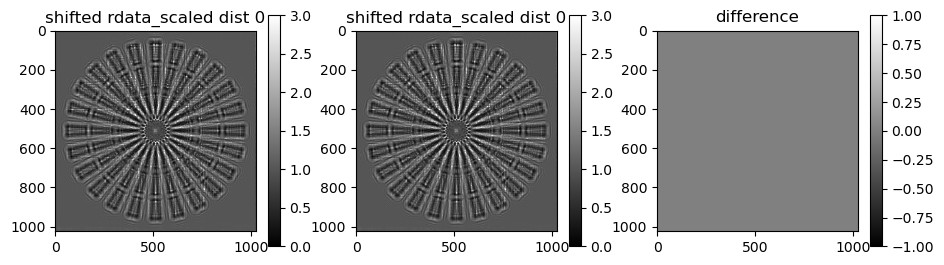

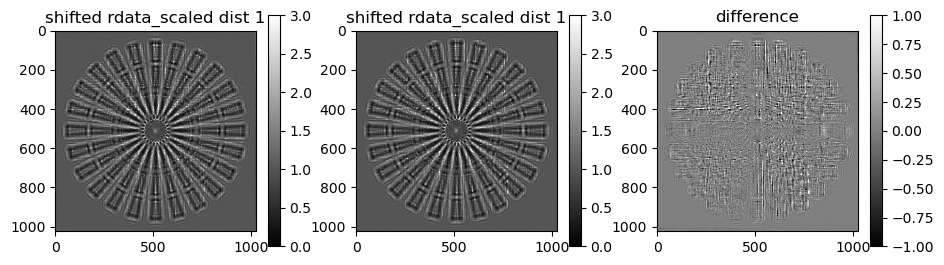

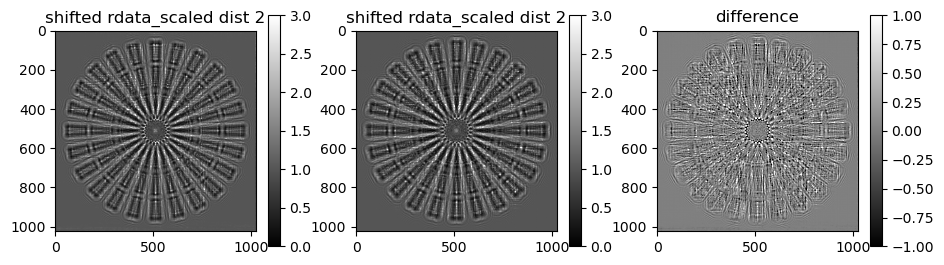

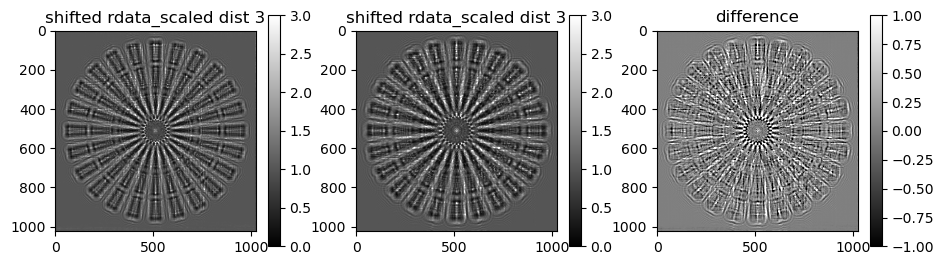

In [12]:
rdata_scaled_aligned = rdata_scaled.copy()
for k in range(ndist):
    rdata_scaled_aligned[:, k] = ST(rdata_scaled[:, k], shifts_drift[:, k]/norm_magnifications[k]).real
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    im = axs[0].imshow(rdata_scaled_aligned[0, 0], cmap='gray', vmin=0, vmax=3)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled_aligned[0, k], cmap='gray', vmin=0, vmax=3)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled_aligned[0, k] - rdata_scaled_aligned[0, 0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

#### Reconstruction by the MultiPaganin method

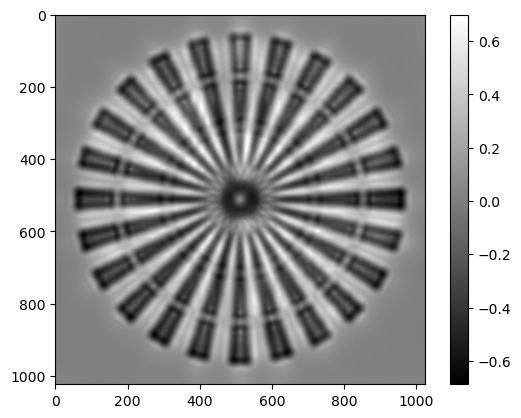

In [13]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = multiPaganin(rdata_scaled_aligned, distances_pag, wavelength, voxelsize, 10, 1e-12)
plt.imshow(recMultiPaganin[0],cmap='gray')
plt.colorbar()

#### Reconstruction by the CTF pure phase method

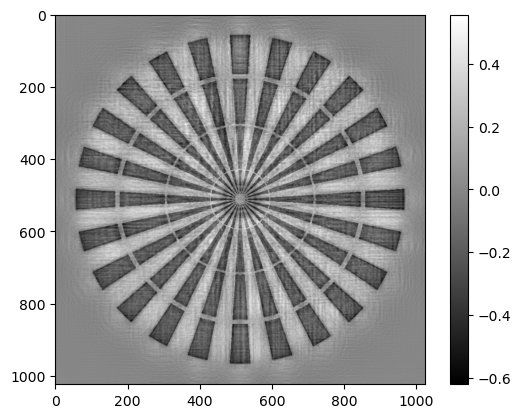

In [14]:
distances_ctf = (distances/norm_magnifications**2)[:ndist]

recCTF = CTFPurePhase(rdata_scaled_aligned, distances_ctf, wavelength, voxelsize, 1e-2)
plt.imshow(recCTF[0],cmap='gray')
plt.colorbar()